### 가위바위보 라벨링 진행 

In [86]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split


def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=7800   # 가위바위보 이미지 개수
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)  # 0으로 호기화된 ndarray 배열 객체 반환

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

trImage_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_2"
data,label=load_data(trImage_dir_path)

# 훈련 데이터의 25%는 검증 셋으로 나머지는 훈련용 데이터로 분할하는 코드이다.
# 데이터가 각 사람마다 0~99, 100~199... 등으로 순차적으로 들어가 있기에 
# batch를 나눌 경우 제대로 학습이 안될 수 있어서 shuffle=True를 옵션을 사용한다.
# stratify을 label로 지정해서 각각의 class비율을 train / test에 유지 시켜준다. (한쪽에 쏠리는 경우 방지)
# random_state=30 데이터 셋을 shuffle할 때 해당 int값을 보고 섞어서, 매번 데이터셋이 변경되는것을 방지
x_train, x_valid, y_train,y_valid = train_test_split(
    data,label, test_size=0.2, shuffle=True, stratify=label, random_state=40)

# train, test 데이터 255로 나누어서 0~1의 값으로 정규화
x_train_norm = x_train/255.0 
x_valid_norm = x_valid/255.0  

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("x_test shape: {}".format(x_valid.shape))
print("y_test shape: {}".format(y_valid.shape))

학습데이터(x_train)의 이미지 개수는 7800 입니다.
x_train shape: (6240, 28, 28, 3)
y_train shape: (6240,)
x_test shape: (1560, 28, 28, 3)
y_test shape: (1560,)


### 딥러닝 네트워크 설계

In [97]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense
import numpy as np
tf.random.set_seed(2) # 실험환경 셋팅 seed 고정
# 채널로 구성
n_channel_1=64
n_channel_2=128
n_channel_3=128
n_channel_4=64
n_dense=128

model=keras.models.Sequential()  # padding='same' 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
model.add(Conv2D(n_channel_1, (3,3),padding='same', activation='relu', input_shape=(28,28,3)))
model.add(MaxPooling2D(2,2))
# 컨볼루션 신경망 레이어 사용 (3x3)) 필터의 개수 64 활성화 함수(activation) =relu 설정[은익층으로 역전파를 통해 좋은 성능이 나온다.],
# input_shape= 이미지 크기 28x28 픽셀  [ RGB 값해서 3의 값을 가져서 (28,28,3)이 된다.]
model.add(Conv2D(n_channel_2, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.4))  # dropout : 과적합(overfit) 문제 해결 

model.add(Conv2D(n_channel_3, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(n_channel_4, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.6))  # dropout : 과적합(overfit) 문제 해결 (0.6 이하 버림) 
model.add(Dense(n_dense, activation='relu'))   #
model.add(Dense(3, activation='softmax'))   # softmax : 클래스 분류 문제에서 사용 =

print(model.summary())
print('Model에 추가된 Layer 개수: ', len(model.layers))


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 3, 3, 128)       

### k fold cross validation (교차 검증)
- 데이터의 대한 검증이 잘 이루어졌나 확인하기 위해 사용

In [117]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense
import numpy as np
from sklearn.model_selection import KFold
tf.random.set_seed(1) # 실험환경 셋팅 seed 고정
# 채널로 구성
n_channel_1=64
n_channel_2=64
n_channel_3=128
n_channel_4=64
n_dense=128
k_fold = KFold(n_splits=3, shuffle=True)  # 데이터가 3개의 fold로 나뉘고 순차적으로 나뉘는게 아닌 섞인 상태에서 무작위로 지정된다.
accuracy = []

for train, valid in k_fold.split(data, label) :   # 교차 검증을 사용해 모델의 정확도를 검증한다.  n_splits=3, 3번 반복(fold의 개수는 3)
    
    model=keras.models.Sequential()  # padding='same' 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
    model.add(Conv2D(n_channel_1, (3,3),padding='same', activation='relu', input_shape=(28,28,3)))
    model.add(MaxPooling2D(2,2))
# 컨볼루션 신경망 레이어 사용 (3x3)) 필터의 개수 64 활성화 함수(activation) =relu 설정[은익층에 주로 사용] input_shape= 이미지 크기 28x28 픽셀
# RGB 값해서 3의 값을 가져서 (28,28,3)이 된다.
    model.add(Conv2D(n_channel_2, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Dropout(0.3))  # dropout : 과적합(overfit) 문제 해결 

    model.add(Conv2D(n_channel_3, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Conv2D(n_channel_4, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(keras.layers.Flatten())
    model.add(Dense(n_dense, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
    model.fit(data, label, epochs=10,
                    batch_size=20, validation_data=(x_test_norm, y_test))
    
    kFold_accuracy = '%.5f' % (model.evaluate(data[valid], label[valid])[1])
    accuracy.append(kFold_accuracy)

print(model.summary())
print('Model에 추가된 Layer 개수: ', len(model.layers))
print("kfold accuracy :", accuracy)
print("평균 kfold accuracy :", kFold_accuracy )

Epoch 1/10
390/390 [==============================] - 1s 2ms/step - loss: 1.2117 - accuracy: 0.4559 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 2/10
390/390 [==============================] - 1s 2ms/step - loss: 0.6780 - accuracy: 0.6909 - val_loss: 1.0983 - val_accuracy: 0.3333
Epoch 3/10
390/390 [==============================] - 1s 2ms/step - loss: 0.4660 - accuracy: 0.8036 - val_loss: 1.0974 - val_accuracy: 0.3333
Epoch 4/10
390/390 [==============================] - 1s 2ms/step - loss: 0.3658 - accuracy: 0.8532 - val_loss: 1.0975 - val_accuracy: 0.3333
Epoch 5/10
390/390 [==============================] - 1s 2ms/step - loss: 0.2935 - accuracy: 0.8827 - val_loss: 1.0975 - val_accuracy: 0.3333
Epoch 6/10
390/390 [==============================] - 1s 2ms/step - loss: 0.2489 - accuracy: 0.9000 - val_loss: 1.0982 - val_accuracy: 0.3333
Epoch 7/10
390/390 [==============================] - 1s 2ms/step - loss: 0.1841 - accuracy: 0.9294 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 

### 딥러닝 네트워크 학습

In [98]:
from tensorflow.keras.optimizers import Adam
# categorical_crossentropy

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(lr=0.0005, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
#model_history = model.fit(x_train, y_train, epochs=10)
#keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
# Adam 말고 다른 방식의 학습을 시도했지만 Adam이 제일 괜찮은 결과를 보였다.
model_his=model.fit(x_train_norm, y_train, epochs=15,
                    batch_size=40,
                   validation_data=(x_valid_norm, y_valid))
# model.fit()에 대한 데이터를 model_his에 저장시켜 valid 데이터와 train데이터의 정확도 그래프를 그려본다.

Epoch 1/15
156/156 [==============================] - 1s 4ms/step - loss: 1.0983 - accuracy: 0.3452 - val_loss: 1.0875 - val_accuracy: 0.3827
Epoch 2/15
156/156 [==============================] - 0s 3ms/step - loss: 0.9496 - accuracy: 0.5253 - val_loss: 0.7513 - val_accuracy: 0.6737
Epoch 3/15
156/156 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.7072 - val_loss: 0.5080 - val_accuracy: 0.8173
Epoch 4/15
156/156 [==============================] - 0s 3ms/step - loss: 0.5107 - accuracy: 0.7946 - val_loss: 0.3376 - val_accuracy: 0.8769
Epoch 5/15
156/156 [==============================] - 1s 3ms/step - loss: 0.3665 - accuracy: 0.8596 - val_loss: 0.2199 - val_accuracy: 0.9340
Epoch 6/15
156/156 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.9179 - val_loss: 0.1235 - val_accuracy: 0.9603
Epoch 7/15
156/156 [==============================] - 1s 3ms/step - loss: 0.1830 - accuracy: 0.9322 - val_loss: 0.1150 - val_accuracy: 0.9513
Epoch 

### train, valid 확인 그래프
- model.fit()에서 validation_data=(x_valid_norm, y_valid))를 가지고 오른쪽 아래로 내려가는 그래프를 그렸다.
- 오른쪽 아래로 내려가서 0에 가까워 질수록 훈련 데이터가 검증 데이터에 대한 정확도가 높다.
- 2개의 데이터가 서로 비슷한 방향과 가까운 거리일 수록 잘 학습된 데이터이다.

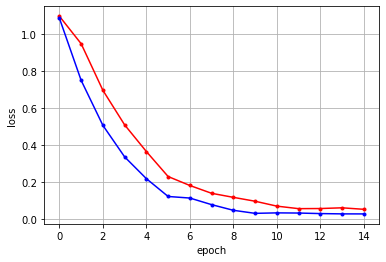

In [99]:
y_loss = model_his.history['loss']
y_val_loss = model_his.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 딥러닝 네트워크 테스트 데이터 (검증)

In [100]:
# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.
import os
def load_data(img_path) :
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [106]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
import random
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


# loss 데이터 확인
predicted_result= model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

10/10 - 0s - loss: 1.3462 - accuracy: 0.6633
test_loss: 1.3462342023849487 
test_accuracy: 0.6633333563804626


### 예측하는데 실패한 test 데이터 보기

예측확률분포: [0.37192628 0.00249155 0.6255822 ]
라벨: 1, 예측결과: 2


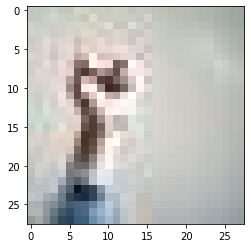

예측확률분포: [0.3821236 0.3806609 0.2372155]
라벨: 1, 예측결과: 0


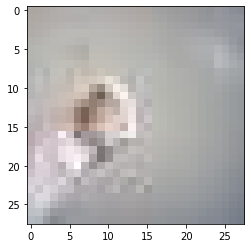

예측확률분포: [2.2114123e-01 7.6608168e-04 7.7809268e-01]
라벨: 0, 예측결과: 2


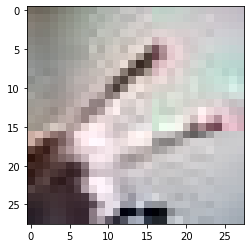

예측확률분포: [0.98240066 0.00144218 0.01615713]
라벨: 1, 예측결과: 0


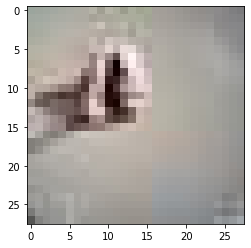

예측확률분포: [0.31603864 0.00091608 0.6830453 ]
라벨: 0, 예측결과: 2


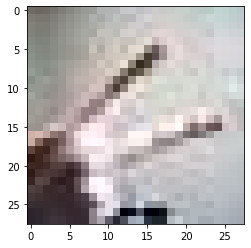

예측확률분포: [0.20349567 0.01381907 0.7826853 ]
라벨: 0, 예측결과: 2


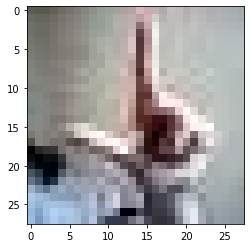

예측확률분포: [3.9027372e-01 7.8978832e-05 6.0964733e-01]
라벨: 0, 예측결과: 2


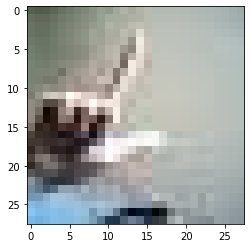

예측확률분포: [9.951739e-01 5.153685e-04 4.310849e-03]
라벨: 1, 예측결과: 0


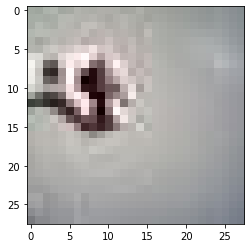

예측확률분포: [0.70634395 0.1156992  0.1779568 ]
라벨: 1, 예측결과: 0


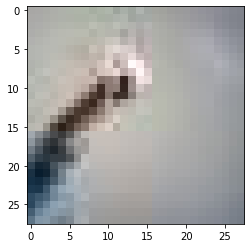

예측확률분포: [1.2281144e-04 2.6280275e-06 9.9987459e-01]
라벨: 0, 예측결과: 2


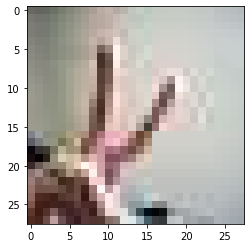

예측확률분포: [0.9897736  0.00244822 0.00777823]
라벨: 1, 예측결과: 0


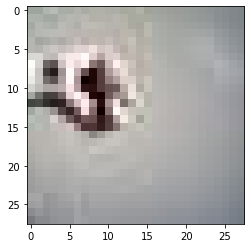

예측확률분포: [0.9459565  0.01302263 0.04102087]
라벨: 1, 예측결과: 0


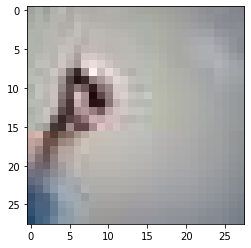

예측확률분포: [5.4982054e-04 2.3607104e-06 9.9944776e-01]
라벨: 0, 예측결과: 2


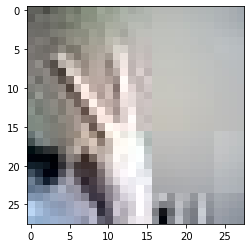

예측확률분포: [0.8491696  0.01233442 0.1384959 ]
라벨: 2, 예측결과: 0


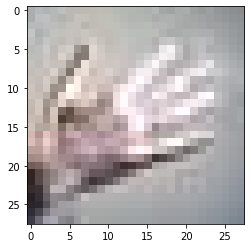

예측확률분포: [0.00132086 0.46601045 0.53266865]
라벨: 0, 예측결과: 2


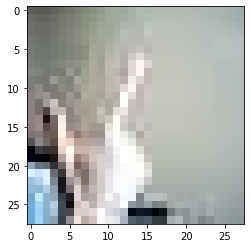

In [108]:
wrong_predict_list=[]

for i, _ in enumerate(predicted_labels):
    # i번째 예측한 라벨과 실제 라벨이 다른 경우
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 15개 확인
samples = random.choices(population=wrong_predict_list, k=15)  

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)  # binary를 이미지로 보여주는 imshow
    plt.show()

#### 위의 15개의 이미지를 랜덤으로 여러번 확인해본 결과 
#### 대체로 손이 그늘지거나 주변 손보다 어두운 경우 모델이 예측을 실패했다.

### Image Genetator  test
#### (이미지 개수 증가시키기)
- 데이터의 개수가 부족해서 정확도가 낮은것 같아서 Image Genetator 시도해서 이미지를 늘렸다.

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
# rescale ="이미지 크기 변경", rotation_range ="이미지 회전", zoom_range="이미지 확대/축소"
# horizontal_flip ="이미지 수평 반전" 등을 해서 이미지를 생성시키는 ImageDataGenerator이다.

test_datagen = ImageDataGenerator(rescale=1./255)  # test 데이터는 이미지 크기만 조정해서 데이터 생성

train_generator = train_datagen.flow_from_directory('/home/ssac27/aiffel/imgGeneator test',
                                                 target_size = (28,28),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
# 폴더명에 맞춰서 라벨링 해주기 위한 'flow_from_directory' 훈련 이미지 가져오기

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(28, 28),
        batch_size=32,
        class_mode='binary')
# 검증데이터 flow_from_directory로 폴더명에 맞춰 라벨링해준 후 불러오기

#batch_size 크기에 맞춰서 이미지를 가지고 온다.

Found 3 images belonging to 3 classes.


## 회고

- 과적합을 해결하기위해 DropOut을 사용하고 0~1로 테이터 정규화를 사용했다. 그리고 train_test_split를 사용해 훈련 데이터가 valid를 통해 제대로 된 훈련을하게 만들었지만 데이터의 개수가 10000개를 넘지못해 정확도가 생각보다 덜 나온것 같다.


- k-fold로 검증을 진행하고 model.fit(validation_data)그래프로 훈련 데이터와 검증 데이터를 눈으로 확인하면서 하이퍼 파라미터 값을 조정하니 처음20~40%에 달하는 정확도가 50%이상으로 금세 올라간것을 확인했다. 


- 위의 작업들을 계속 반복하면서 모델학습에서 검증 과정의 중요성을 알게된것 같다.


- 모델을 만들면서 처음에는 쉽게만 여겨졌던 프로젝트가 생각보다 많이 어려워서 좀 더 열심히 해야겠단 생각이 듭니다.